In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Fault Condition 4 is all about the "operating states of the AHU." 

* Or in English refers to how often is the AHU program jumping into a heating, cooling, economizer, back to heating, then economizing, then mechanical cooling.... DDC programs that are not tuned, believe it or not they can do that!

Schematic below is from this blog about HVAC: https://www.hvacbrain.com/blog/vav-versus-vvt/

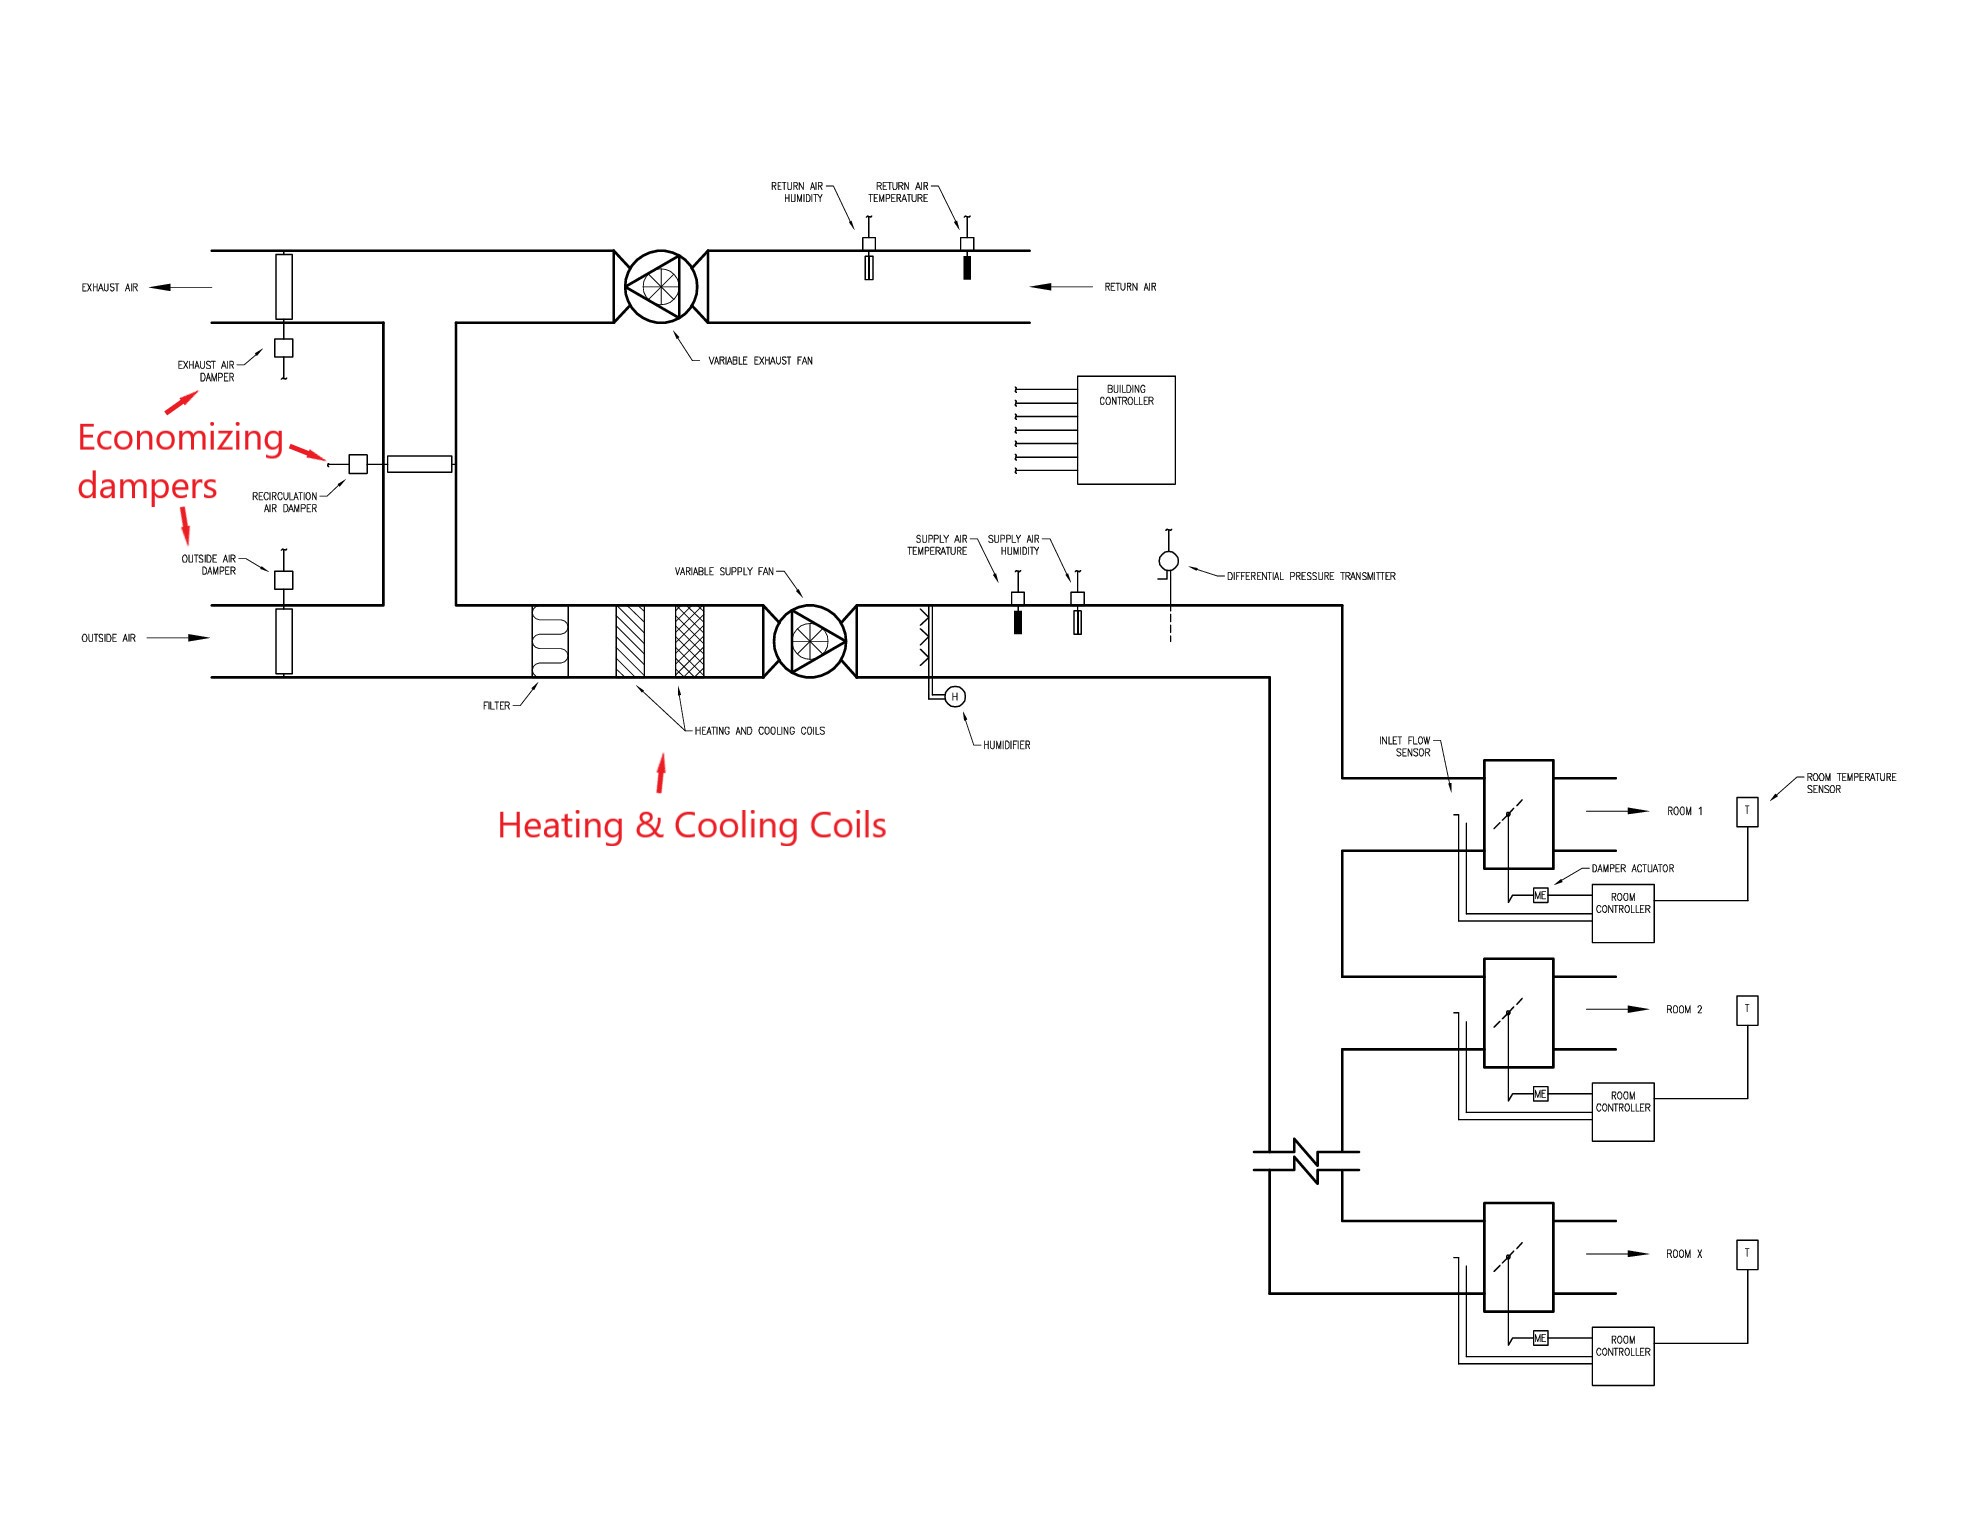

# Like FC 1,2,3, FC4 measure applies to all conditions for the AHU

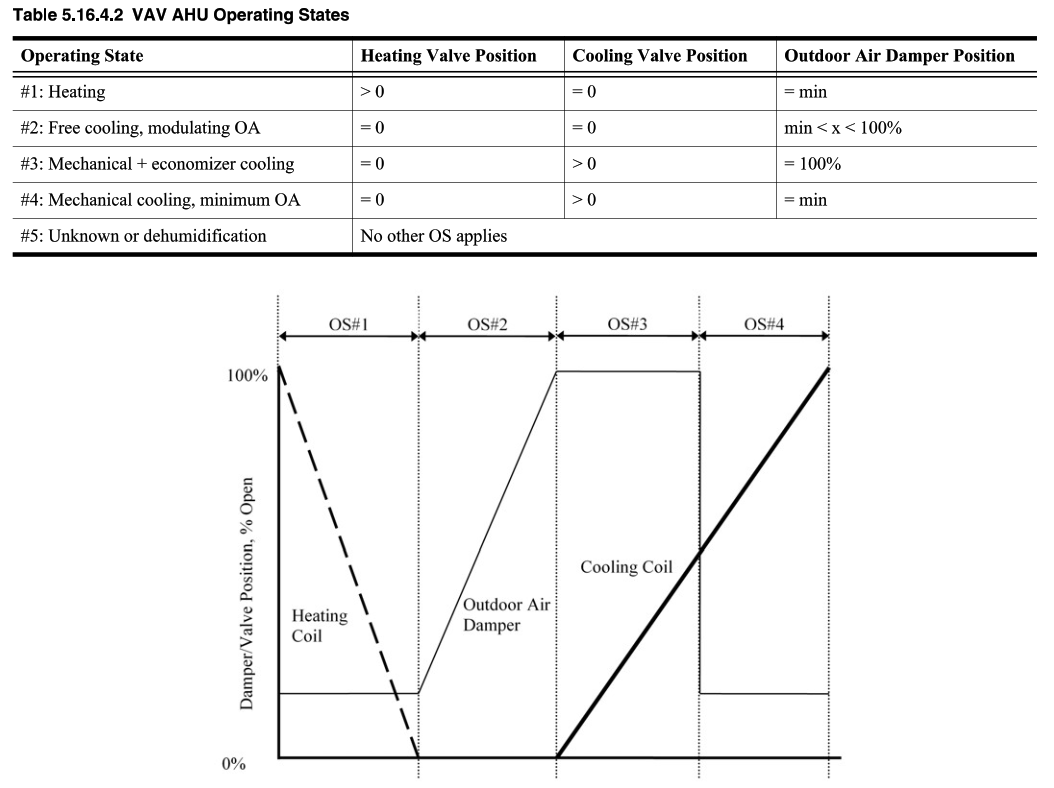

* This image above denotes a heating mode, economizer mode, economizer + mechanical cooling, and mechanical cooling only moving left to right based on the data coming from the heating valve, outside air damper, and cooling.

# Snip of ASHRAE Fault Condition 4

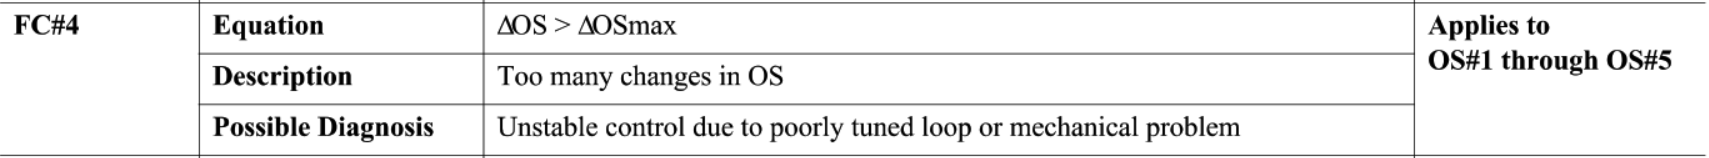

* Note that this equation cannot directly be translated into code but I think the image above can be useful for defining "OS" operating states based on heating valve signal, cooling valve signal, and the outside air damper signal.

In [2]:
def fault_condition_four(dataframe):
    return (dataframe.mat + dataframe.mix_degf_err_thres < np.minimum((dataframe.rat - dataframe.return_degf_err_thres) , (dataframe.oat - dataframe.outdoor_degf_err_thres)))

# Read Associated CSV files forward fill dataset and remove NaNs

In [3]:
rtu_os_states = pd.read_csv('./shoulder_season_data/RTU Data-fc4-2021-11-15 07_10_01.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()

* Note rolling average not computed for this measure


In [4]:
rtu_os_states.columns

Index(['slipstream_internal/slipstream_hq/1100/Cooling Capacity Status',
       'slipstream_internal/slipstream_hq/1100/Heating Capacity Primary Status',
       'slipstream_internal/slipstream_hq/1100/Outdoor Air Damper Command'],
      dtype='object')

In [5]:
# rename columns
rtu_os_states.rename(columns={'slipstream_internal/slipstream_hq/1100/Cooling Capacity Status': 'cooling_sig', # discharge air temp not needed
                   'slipstream_internal/slipstream_hq/1100/Heating Capacity Primary Status': 'heating_sig',
                   'slipstream_internal/slipstream_hq/1100/Outdoor Air Damper Command': 'economizer_sig'}, inplace=True)

In [6]:
rtu_os_states.columns

Index(['cooling_sig', 'heating_sig', 'economizer_sig'], dtype='object')

In [7]:
# small dataset logged from VOLTTRON on 1 min intervals.
# In economizer season November


rtu_os_states.describe()

,cooling_sig,heating_sig,economizer_sig
count,10080.000000,10080.000000,10080.000000
mean,0.195846,2.506149,19.834088
std,1.218951,13.113482,29.467393
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,52.300000
max,10.700000,100.000000,100.000000


# Plot data for visulation 

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

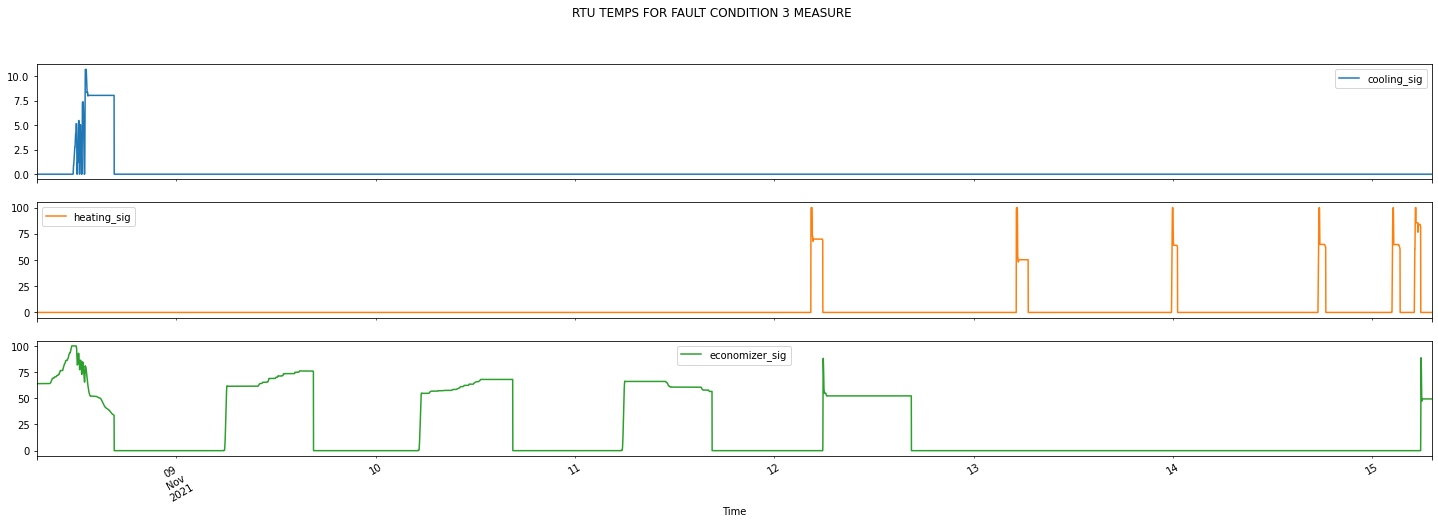

In [8]:
rtu_os_states.plot(figsize=(25,8), subplots=True, title='RTU TEMPS FOR FAULT CONDITION 3 MEASURE')

* Note just by looking at this chart its easy to see that there is not a lot of different "modes" happening. Some mechanical cooling + economizer cooling on the left and as we look towards the right the AHU transitions into just economizing, and then finally just heating. Its also worth noting economizer + mechanical cooling is OK based on if conditions outside are suitable for "free cooling" but economizing and heating is NEVER okay. Economizing and heating is like driving down the highway in a car with running both the gas and brake pedal at the same time.

# Set Internal Variables per G36 Spec Imperial Units

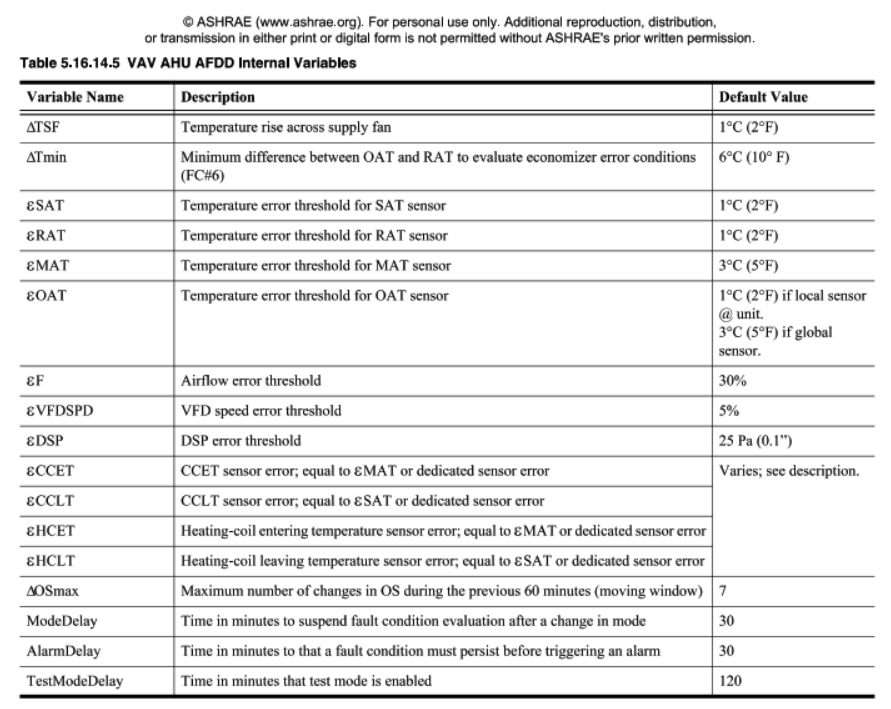

In [9]:
supply_fan_delta_degf = 2.
oat_rat_delta_degf_min = 10.
supply_degf_err_thres = 2.
return_degf_err_thres = 2.
mix_degf_err_thres = 5.
outdoor_degf_err_thres = 5. 
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7. # <----- THIS PARAM on FC4
mode_delay = 30.
alarm_dely = 30.
test_mode_delay = 120.

# Param from BAS for AHU min OA setpoint determined by balancing contractor

In [10]:
ahu_min_oa = 20

In [11]:
# make an entire column out of these params in the Pandas Dataframe
rtu_os_states['delta_os_max'] = delta_os_max
rtu_os_states['ahu_min_oa'] = ahu_min_oa

In [12]:
rtu_os_states.columns

Index(['cooling_sig', 'heating_sig', 'economizer_sig', 'delta_os_max',
       'ahu_min_oa'],
      dtype='object')

# LETS look again at the OS states:

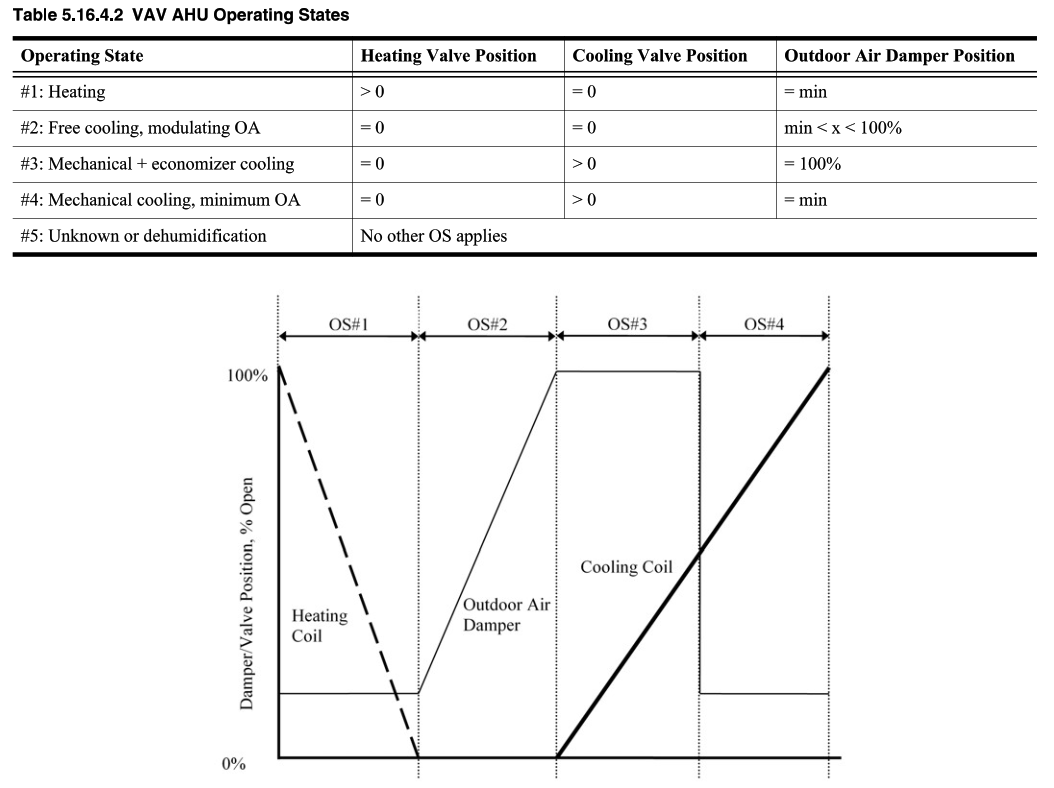

In [30]:
rtu_os_states['heating_mode'] = rtu_os_states['heating_sig'].gt(0.)
rtu_os_states['econ_mode'] = rtu_os_states['economizer_sig'].gt(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].eq(0.)
rtu_os_states['econ+mech_cooling'] = rtu_os_states['economizer_sig'].gt(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].gt(0.)
rtu_os_states['mech_cooling'] = rtu_os_states['economizer_sig'].eq(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].gt(0.)

In [31]:
# Create a debug dataframe for later
rtu_os_states_debug =  rtu_os_states.copy()

In [32]:
rtu_os_states.columns

Index(['cooling_sig', 'heating_sig', 'economizer_sig', 'delta_os_max',
       'ahu_min_oa', 'heating_mode', 'econ_mode', 'econ+mech_cooling',
       'mech_cooling'],
      dtype='object')

In [33]:
rtu_os_states['heating_mode'].value_counts()

False    9704
True      376
Name: heating_mode, dtype: int64

In [34]:
rtu_os_states['econ_mode'].value_counts()

False    7140
True     2940
Name: econ_mode, dtype: int64

In [35]:
rtu_os_states['econ+mech_cooling'].value_counts()

False    9794
True      286
Name: econ+mech_cooling, dtype: int64

In [36]:
rtu_os_states['mech_cooling'].value_counts()

False    10080
Name: mech_cooling, dtype: int64

In [37]:
rtu_os_states

,cooling_sig,heating_sig,economizer_sig,delta_os_max,ahu_min_oa,heating_mode,econ_mode,econ+mech_cooling,mech_cooling
Time,,,,,,,,,
2021-11-08 07:10:00,0.0,0.0,64.0,7.0,20,False,True,False,False
2021-11-08 07:11:00,0.0,0.0,64.0,7.0,20,False,True,False,False
2021-11-08 07:12:00,0.0,0.0,64.0,7.0,20,False,True,False,False
2021-11-08 07:13:00,0.0,0.0,64.0,7.0,20,False,True,False,False
2021-11-08 07:14:00,0.0,0.0,64.0,7.0,20,False,True,False,False
...,...,...,...,...,...,...,...,...,...
2021-11-15 07:05:00,0.0,0.0,49.4,7.0,20,False,True,False,False
2021-11-15 07:06:00,0.0,0.0,49.4,7.0,20,False,True,False,False
2021-11-15 07:07:00,0.0,0.0,49.4,7.0,20,False,True,False,False


# Run dataset through the function created for FC3 to FLAG some faults!

In [21]:
rtu_os_states['fc4_flag'] = fault_condition_three_(rtu_os_states)

NameError: name 'fault_condition_three_' is not defined

In [ ]:
rtu_os_states['fc4_flag'].value_counts()

In [ ]:
rtu_os_states.columns

In [ ]:
# change boolean column to int for plots

rtu_os_states['fc4_flag'] = rtu_os_states['fc4_flag'].astype(int)

# drop params column for better plot
rtu_temps_avg = rtu_temps_avg.drop(['outdoor_degf_err_thres',
                  'mix_degf_err_thres',
                  'return_degf_err_thres'],axis=1)


In [ ]:
fdd_plot = rtu_temps_avg

In [ ]:
fdd_plot.columns

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))

plot1a = fdd_plot.mat.plot(ax=ax)
plot1b = fdd_plot.rat.plot(ax=ax)
plot1c = fdd_plot.oat.plot(ax=ax)
plot1d = fdd_plot.fc3_flag.plot(ax=ax, color='k', secondary_y=True)

ax.set_ylabel('RTU Temperatures')
ax.right_ax.set_ylim(0,1)
plt.ylabel('FDD FLAG')

ax.set_title("RTU Temp Sensors and FDD 3 Flag")
fig.legend(['mat','rat','oat','fc2_flag'],bbox_to_anchor=(.95, .9))

# defining display layout
plt.tight_layout()

# show plot
plt.show()


In [ ]:
zoom_date = '2021-8-10'
fdd_plot_zoom1 = fdd_plot.loc[zoom_date]

# code here is to make the zoom plot x axis readable with units of time
fdd_plot_zoom1.index = fdd_plot_zoom1.index.map(lambda x: x.strftime("%H:%M"))

fdd_plot_zoom1.head()

In [ ]:
fig1, ax = plt.subplots(figsize=(25,8))

fdd_plot_zoom1.mat.plot(ax=ax)
fdd_plot_zoom1.rat.plot(ax=ax)
fdd_plot_zoom1.oat.plot(ax=ax)
fdd_plot_zoom1.fc3_flag.plot(ax=ax, color='k', secondary_y=True)

ax.set_ylabel('RTU Temperatures')
ax.right_ax.set_ylim(0,1)
plt.ylabel('FDD FLAG', rotation=-90)

ax.set_title("RTU Temp Sensors and FDD 3 Flag on " + zoom_date)
fig.legend(['mat','rat','oat','fc3_flag'],bbox_to_anchor=(.95, .9))

# defining display layout
plt.tight_layout()

# show plot
plt.show()

# WHY NO FAULTS?

* maybe look at our equation again....? Which is opposite of FC2

return mat - mat_err > max((rat + rat_err) , (oat + oat_err))

In [ ]:
# use our debug dataframe created earlier

# IS THIS CALC
rtu_temps_debug['mix_err_calc'] = rtu_temps_debug.mat - rtu_temps_debug.mix_degf_err_thres

# GREATER THAN THE MIN OF THIS CALC!!!!
rtu_temps_debug['return_err_calc'] = rtu_temps_debug.rat + rtu_temps_debug.return_degf_err_thres
rtu_temps_debug['outdoor_err_calc'] = rtu_temps_debug.oat + rtu_temps_debug.outdoor_degf_err_thres

rtu_temps_debug.head()

In [ ]:
rtu_temps_debug = rtu_temps_debug.drop(['return_degf_err_thres',
                                        'outdoor_degf_err_thres',
                                        'mix_degf_err_thres',
                                        'oat',
                                        'mat',
                                        'rat'],axis=1)

rtu_temps_debug.head()

In [ ]:
rtu_temps_debug.describe()

# DOES THE BLUE LINE EVER RISE ABOVE THE MAX OF EITHER THE ORANGE OR GREEN LINE? 

* looks like a big fat no, so maybe the mixing air temperature sensor is reading legit values

In [ ]:
rtu_temps_debug.plot(figsize=(25,8))

# The second D in FDD is "Diagnostics"

No diagnostics on this one as there appears to be no FLAGS!

* Calculate percent TRUE AND FALSE of FDD Flag

In [ ]:
percent_true = rtu_temps_avg.fc3_flag.mean()

print("Percent of time in the dataset when FLAG is True")

percent_true

In [ ]:
percent_false = 1 - percent_true

print("Percent of time in the dataset when FLAG is False")

percent_false

* Calculate elapsed time for fault conditions True

In [ ]:
fc3_dataset_copy = rtu_temps_avg.copy()


#filter dataset for when "FLAG" is True
fc3_dataset_copy = fc3_dataset_copy[fc3_dataset_copy.fc3_flag == 1]


In [ ]:
fc3_dataset_copy.fc3_flag.sum()

In [ ]:
fc3_dataset_copy['time_td'] = fc3_dataset_copy.index.to_series().diff().astype('timedelta64[m]')

In [ ]:
print("TIME IN MINUTES the FLAG is TRUE")

fc3_dataset_copy.time_td.sum()

In [ ]:
print("TIME IN HOURS the FLAG is TRUE")

fc3_dataset_copy.time_td.sum() / 60

* Plot on histogram the hour of the day the "FLAG" is TRUE

In [ ]:
fc3_dataset_copy['hour_of_the_day'] = fc3_dataset_copy.index.hour

fc3_dataset_copy.hour_of_the_day.plot.hist(title='Hour Of Day When Flag is TRUE',figsize=(25,8))

In [ ]:
print("Mix Air Temp Average for dataset when FLAG IS TRUE")

fc3_dataset_copy.mat.mean()